# VGG16 for CIRFAR10 data set

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


讀取資料並標準化

In [3]:
from keras.datasets import cifar10   
(train_x, train_y), (test_x, test_y) = cifar10.load_data() 
train_x = np.append(train_x, test_x).astype(np.float32)
train_y = np.append(train_y, test_y)
train_x = train_x.reshape((60000, 32, 32, 3))
train_y = train_y.reshape(60000)
test_x = test_x.astype(np.float32)
test_y = test_y.reshape(10000)
for i in range(60000):
  train_x[i, :, :, 0] = (train_x[i, :, :, 0] - train_x[i, :, :, 0].mean()) / train_x[i, :, :, 0].std()
  train_x[i, :, :, 1] = (train_x[i, :, :, 1] - train_x[i, :, :, 1].mean()) / train_x[i, :, :, 1].std()
  train_x[i, :, :, 2] = (train_x[i, :, :, 2] - train_x[i, :, :, 2].mean()) / train_x[i, :, :, 2].std()
  train_x[i, :, :, 0] = (train_x[i, :, :, 0] - train_x[i, :, :, 0].min()) / (train_x[i, :, :, 0].max() - train_x[i, :, :, 0].min())
  train_x[i, :, :, 1] = (train_x[i, :, :, 1] - train_x[i, :, :, 1].min()) / (train_x[i, :, :, 1].max() - train_x[i, :, :, 1].min())
  train_x[i, :, :, 2] = (train_x[i, :, :, 2] - train_x[i, :, :, 2].min()) / (train_x[i, :, :, 2].max() - train_x[i, :, :, 2].min())
for i in range(10000):
  test_x[i, :, :, 0] = (test_x[i, :, :, 0] - test_x[i, :, :, 0].mean()) / test_x[i, :, :, 0].std()
  test_x[i, :, :, 1] = (test_x[i, :, :, 1] - test_x[i, :, :, 1].mean()) / test_x[i, :, :, 1].std()
  test_x[i, :, :, 2] = (test_x[i, :, :, 2] - test_x[i, :, :, 2].mean()) / test_x[i, :, :, 2].std()
  test_x[i, :, :, 0] = (test_x[i, :, :, 0] - test_x[i, :, :, 0].min()) / (test_x[i, :, :, 0].max() - test_x[i, :, :, 0].min())
  test_x[i, :, :, 1] = (test_x[i, :, :, 1] - test_x[i, :, :, 1].min()) / (test_x[i, :, :, 1].max() - test_x[i, :, :, 1].min())
  test_x[i, :, :, 2] = (test_x[i, :, :, 2] - test_x[i, :, :, 2].min()) / (test_x[i, :, :, 2].max() - test_x[i, :, :, 2].min())

170508288/170498071 [==============================] - 2s 0us/step


觀察標籤分布

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


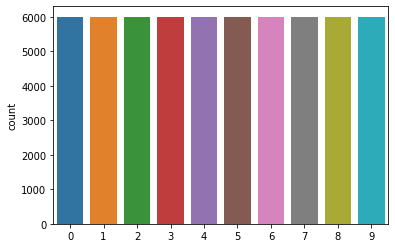

In [4]:

train_y = train_y.reshape(60000)
sns.countplot(train_y)


定義標籤代表的意思

In [5]:
namelist = ["airplane", "automobile", "bird", "cat", "deer",
         "dog", "frag", "horse", "ship", "truck"]

隨機plot九張

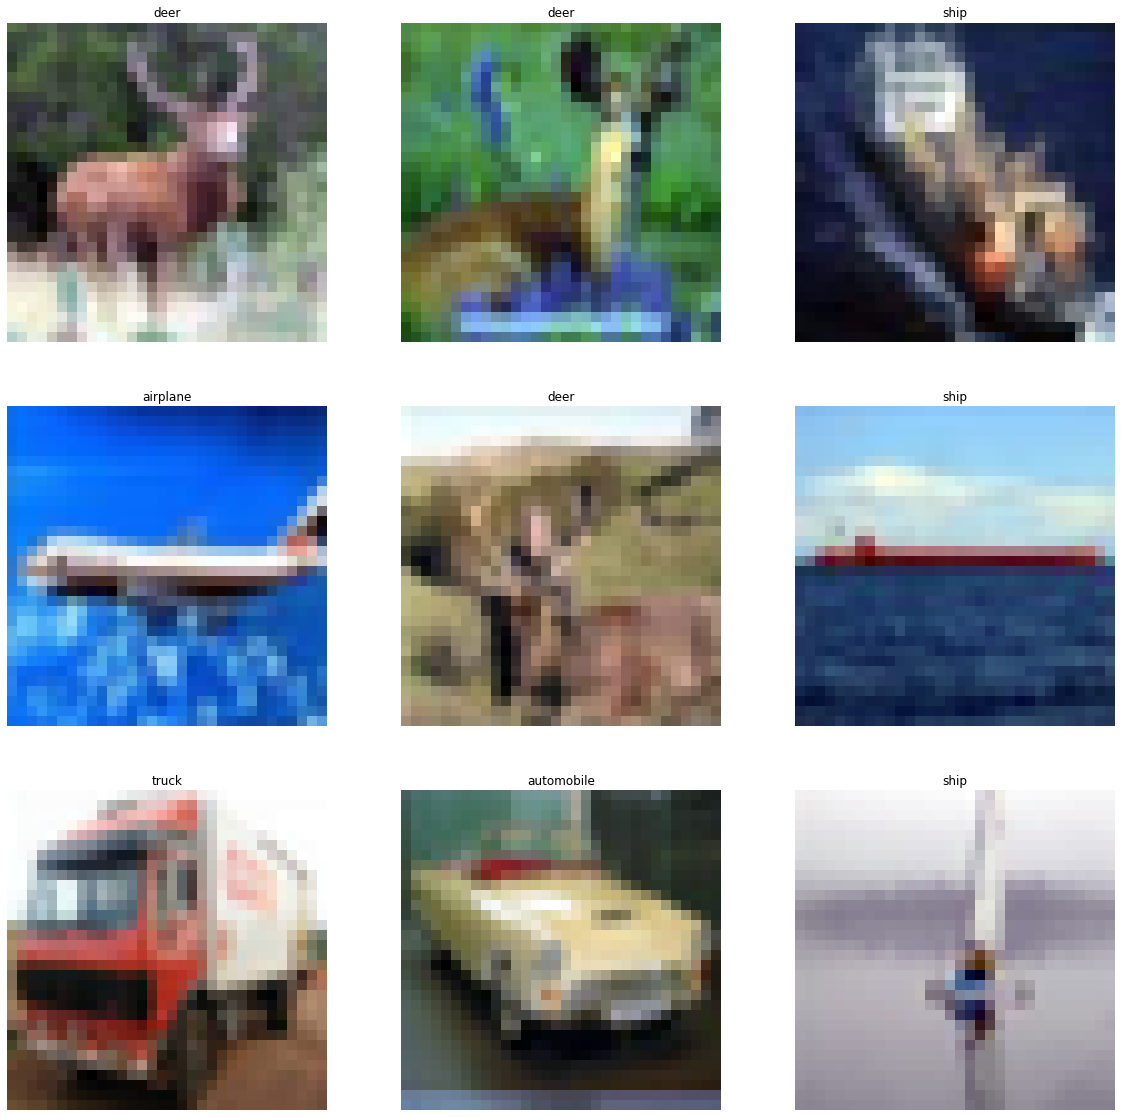

In [6]:
import random
namelist = ["airplane", "automobile", "bird", "cat", "deer",
                "dog", "frag", "horse", "ship", "truck"]
train_y = train_y.reshape(train_y.shape[0])
plt.figure(figsize=(20,20))
for i in range(9):
  myrand = random.randint(0, train_x.shape[0] - 1)
  plt.subplot(3, 3, i + 1)
  plt.axis("off")
  plt.title(namelist[train_y[myrand]])
  plt.imshow(train_x[myrand])
plt.show()

# train model
使用cuda並開始訓練，建立一個線性卷積模型

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
import os

use_tpu = True #@param {type:"boolean"}


if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''


為了加dropout layer而自行串接的VGG16模型

In [9]:
def get_model(input_shape, num_classes):
  # implementation of vgg 16 with batch normolization and dropout layers
  model = keras.Sequential()
  
  model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape = input_shape, padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())





  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(0.5))





  model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  




  
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(keras.layers.Dropout(0.5))





  model.add(keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  
  model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())



  
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(keras.layers.Dropout(0.5))


  
  model.add(keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  #model.add(keras.layers.Dropout(0.2))
  
  model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  #model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())




  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  #model.add(keras.layers.Dropout(0.5))




  model.add(keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  
  model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding = "SAME"))
  model.add(keras.layers.BatchNormalization())


  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # second max polling
  #model.add(keras.layers.Dropout(0.5))
  


  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(64, activation='relu'))

  model.add(keras.layers.Dense(64, activation='relu'))

  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(num_classes, activation='softmax'))

  return model

In [10]:
batch_size = 512
num_classes = 10
epochs = 50

# 定義圖像寬、高
img_rows, img_cols = train_x.shape[1], train_x.shape[2]

input_shape = (img_rows, img_cols, 3)

train_y = keras.utils.to_categorical(train_y, num_classes)

使用CUDA來加速運算

In [11]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.21.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.21.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


keras自己定義的VGG16

In [12]:
"""
VGG defined by keras
internal layers cannot be modified manually, so I use self defined VGG16 at the end
"""
def get_vgg(input_shape, num_classes):
  from keras.applications.vgg16 import VGG16

  myvgg = VGG16(weights=None, include_top=False, input_shape = input_shape)

  model = keras.Sequential()

  model.add(myvgg)

  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(64, activation='relu'))

  model.add(keras.layers.Dense(64, activation='relu'))

  model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(num_classes, activation='softmax'))

  return model

In [13]:
model = get_model(input_shape, num_classes)

opt = keras.optimizers.Adam(learning_rate=0.01)
#opt = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0

In [15]:
# 進行訓練, 訓練過程會存在 train_history 變數中
from sklearn.utils import shuffle
train_x, train_y = shuffle(train_x, train_y)

train_history = model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split= 0.05)

Epoch 1/50
112/112 [==============================] - 198s 2s/step - loss: 2.1468 - accuracy: 0.1655 - val_loss: 2.6208 - val_accuracy: 0.0817
Epoch 2/50
112/112 [==============================] - 195s 2s/step - loss: 1.8824 - accuracy: 0.2264 - val_loss: 3.2540 - val_accuracy: 0.1433
Epoch 3/50
112/112 [==============================] - 195s 2s/step - loss: 1.6914 - accuracy: 0.3233 - val_loss: 2.1858 - val_accuracy: 0.3107
Epoch 4/50
112/112 [==============================] - 195s 2s/step - loss: 1.5502 - accuracy: 0.3886 - val_loss: 1.7148 - val_accuracy: 0.3750
Epoch 5/50
112/112 [==============================] - 196s 2s/step - loss: 1.4246 - accuracy: 0.4571 - val_loss: 1.8857 - val_accuracy: 0.4490
Epoch 6/50
112/112 [==============================] - 195s 2s/step - loss: 1.2796 - accuracy: 0.5429 - val_loss: 2.1633 - val_accuracy: 0.5280
Epoch 7/50
112/112 [==============================] - 196s 2s/step - loss: 1.1497 - accuracy: 0.6050 - val_loss: 1.9060 - val_accuracy: 0.5893

In [16]:
# testing
test_y = test_y.reshape(test_y.shape[0])
"""
test_x = test_x.astype('float32')
test_x /= 255
"""
test_y = keras.utils.to_categorical(test_y, num_classes)

# 顯示損失函數、訓練成果(分數)
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1206793561577797
Test accuracy: 0.9670000076293945


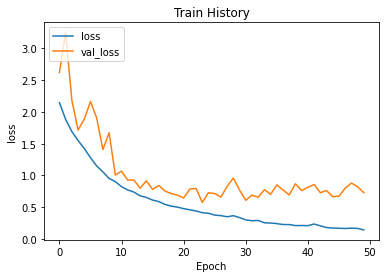

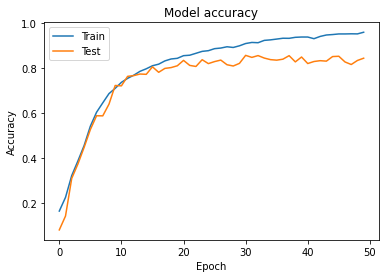

In [17]:
plt.plot(train_history.history['loss'])  
plt.plot(train_history.history['val_loss'])  
plt.title('Train History')  
plt.ylabel('loss')  
plt.xlabel('Epoch')  
plt.legend(['loss', 'val_loss'], loc='upper left')  
plt.show() 

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.save("/content/drive/MyDrive/modelTemp.h5")

#預測資料

In [19]:
predictions = model.predict(test_x)

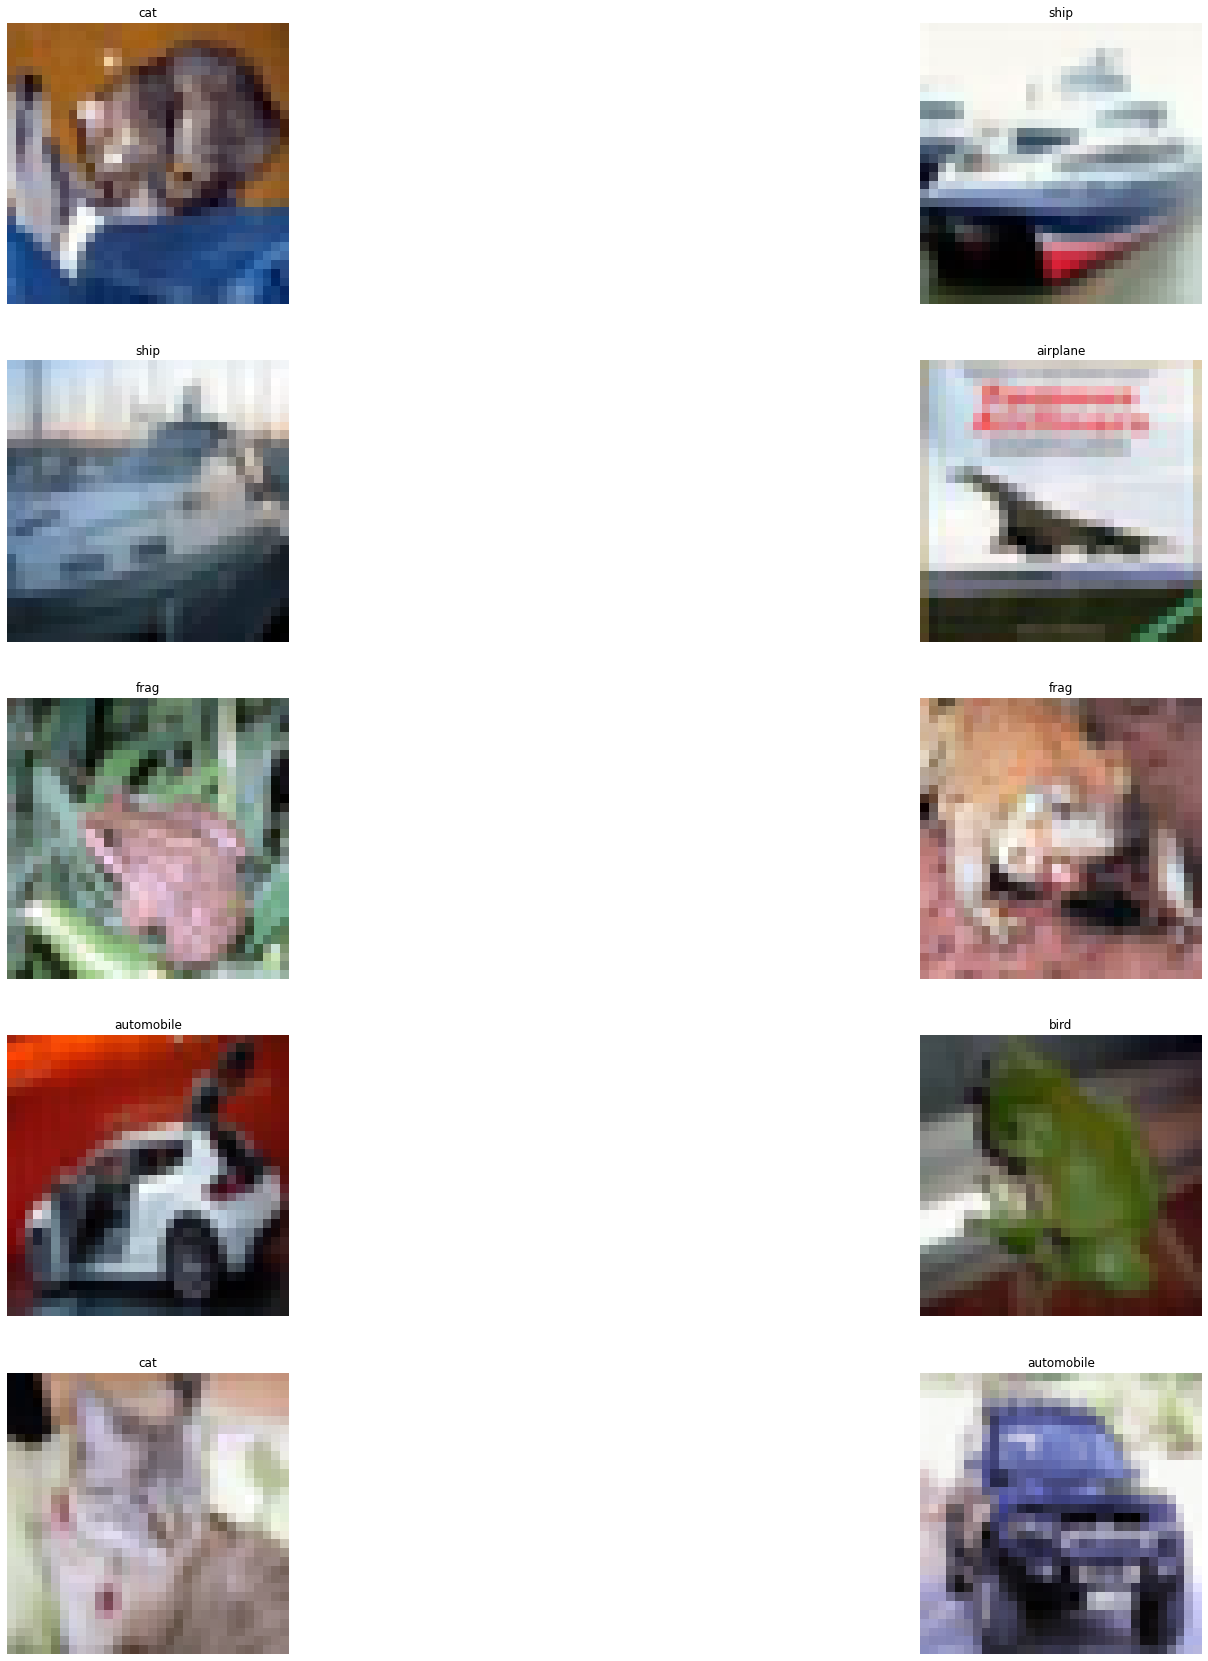

In [20]:
plt.figure(figsize=(30,30))
for i in range(10):
  plt.subplot(5, 2, i + 1)
  plt.axis("off")
  plt.title(namelist[np.where(predictions[i] == predictions[i].max())[0][0]])
  plt.imshow(test_x[i])